# 8.3 2D Homographies

A 2D homography is a very general linear transformation between planes. In the previous notebook we applied rotations and translations to 3D points, which are examples of 3D euclidean homographies.

In computer vision, a homography is usually defined as a **perspective transformation of a plane**, in other workds, a reprojection of a plane from one camera image into a different one, where the camera may have been translated and/or rotated. As a consequence, **any two images of the same planar surface in space are related by a homography**. This has many practical applications, such as image rectification, image registration, augmented reality, etc. 

For 2D homographies, we have a $3x3$ matrix containing the linear transformation:$\\[010pt]$

$$
\begin{bmatrix} a & b & c \\ d & e & f \\ g & h & 1 \end{bmatrix} \begin{bmatrix} x \\ y \\  1\end{bmatrix} 
=  
\begin{bmatrix} u \\ v \\  w\end{bmatrix}\hspace{2cm} \begin{array}{rcr} x' = u\ /\ w \\ y' = v \ / \ w \end{array}\\[5pt] $$ 

<center>
    <img src="./images/intro_homography.png" width="400"/>
</center>$\\[5pt]$

Notice that in such transformation:
- Lines are kept straight.
- Incident lines remain.

**In this notebook we will learn:**

- different types of homographies (<a href="#831">section 8.3.1</a>).
- how to find the parameters for a given homography in 2D (<a href="#832">section 8.3.2</a>).
- under which conditions a homography exists (<a href="#833">section 8.3.3</a>).

## Problem context - Homography in american football

American football is a team sport played by two teams of eleven players on a rectangular field with goalposts at each end. For the cool things we are going to implement we just need to know some points about this sport:  

- The offense (the team with possession of the football) has 4 tries (called downs) for making the ball advance at least 10 yards (approx 9 meters). 
- If a player passes the **down line** (yellow) with the ball, the offense have another 4 tries to advance 10 yards (from the point where the football was lost). 
- **On television, a yellow line is electronically superimposed on the field to show the first down line to the viewing audience. Also, a blue line is superimposed showing where the play (the football) starts.**$\\[10pt]$

<img src="./images/example_football.jpg" width="500"/>$\\[3pt]$

As you can see in the image above, the offense is in the **3rd try** for advancing 10 yards (they advanced 5 yards in previous tries, so **the objective is 5 yards**). That information is given by a rectangle placed in the field showing **3rd (try) & 5 (yards to go)**.

Our objective in this notebook is to **place the blue line** (where the ball starts), the **yellow line** (down line) and the placed **rectangle** (which gives to the audience some information) **using homographies**. Cool, isn't?

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
from math import cos,sin,pi

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
images_path = './images/'

## 8.3.1 2D homography hierarchy levels <a id="831"></a>

But let's start from the beginning. All 2D homographies are linear transformations of 2D points, but there is a hierarchy level where we can distinguish different types of homographies (and, hence, transformations):$\\[10pt]$

<center><img src="./images/types.png" width="450" /></center>$\\[5pt]$

Throughout the next section we will cover these homography types. Let's go!

### <span style="color:orange">LEVEL 1: Translation</span>$\\[5pt]$

$$\lambda \begin{bmatrix}x' \\ y' \\ 1 \end{bmatrix} = \begin{bmatrix} 1 & 0 & t_x \\ 0 & 1 & t_y \\ 0 & 0 & 1 \end{bmatrix}\begin{bmatrix}x \\ y \\ 1 \end{bmatrix} = \lambda \begin{bmatrix}x + t_x \\ y + t_y \\ 1 \end{bmatrix}\\[5pt]$$

Translation is the most simple homography, since pixels of the plane are **only shifted** in both $X$ and $Y$ directions.

### **<span style="color:green"><b><i>ASSIGNMENT 1a: Playing with... wait for it... translation!</i></b></span>**

Your first task is to:

1. Define a transformation matrix `M` that applies an arbitrary translation to the image `football.jpg`. Define such a matrix as having a `float64` format (more info about NumPy data types [here](https://numpy.org/doc/stable/user/basics.types.html)). 

2. Apply such a homography to an image using the OpenCV function [`cv2.warpPerspective()`](https://docs.opencv.org/4.2.0/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87). Take a look at its input arguments.

3. Finally, show both the original and the resulting image.

*Note: The size of the output image depends on the transformation we want to do, but for the following examples you can use the double of the width and height of the original image.*

<font color="blue">Output example:</font>

<img src="./images/translation.png" />

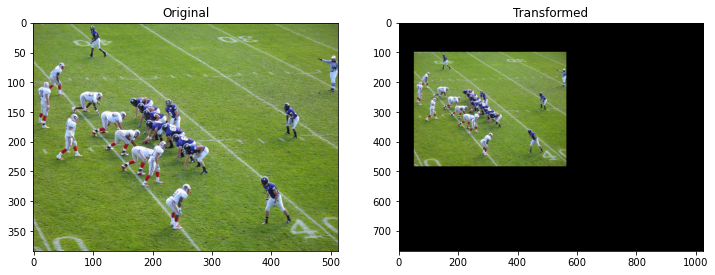

In [2]:
# Write your code here!
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

# Read image
image = cv2.imread(images_path + 'football.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

# Define transformation matrix
M = np.array([[1,0,50],[0,1,100],[0,0,1]], dtype=np.float64)

# Apply homography
n_rows = 2*image.shape[0]
n_cols = 2*image.shape[1]
transformed = cv2.warpPerspective(image, M, (n_cols,n_rows))

# Show the resulting image
plt.subplot(121)
plt.title("Original")
plt.imshow(image)
plt.subplot(122)
plt.title("Transformed")
plt.imshow(transformed);

### <span style="color:orange">LEVEL 2: Euclidean transformation</span>$\\[5pt]$

A linear transformation defining an euclidean (rigid) transformation has the shape:

$$\lambda \begin{bmatrix}x' \\ y' \\ 1 \end{bmatrix} = \begin{bmatrix} cos(\theta) & -sin(\theta) & t_x \\ sin(\theta) & cos(\theta) & t_y \\ 0 & 0 & 1 \end{bmatrix}\begin{bmatrix}x \\ y \\ 1 \end{bmatrix} = \lambda \begin{bmatrix}cos(\theta)x - sin(\theta)y + t_x \\ sin(\theta)x + cos(\theta)y  + t_y \\ 1 \end{bmatrix}\\[5pt]$$

As we saw in the previous notebook, this homography applies **rotation + translation**.  
*Note that rotation is around the origin of coordinates (0,0), which is the top-left corner of the image.*  

### **<span style="color:green"><b><i>ASSIGNMENT 1b: Euclidean transformation comes into play</i></b></span>**

Repeat the previous exercise using an Euclidean transformation, that is:

1. define the transformation matrix `M`,
2. apply it to the image,
3. show the initial and the resulting images.

<font color="blue">Output example:</font>

<img src="./images/euclidean_transformation.png" />

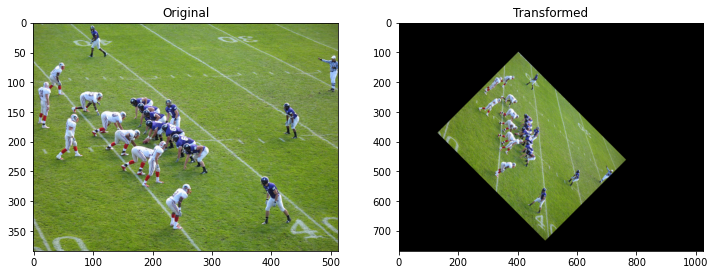

In [3]:
# Write your code here!

# Define transformation matrix
theta = pi/4
M = np.array([[cos(theta),-sin(theta),400],[sin(theta),cos(theta),100],[0,0,1]], dtype=np.float64)

# Apply homography
n_rows = 2*image.shape[0]
n_cols = 2*image.shape[1]
transformed = cv2.warpPerspective(image, M, (n_cols,n_rows))

# Show the resulting image
plt.subplot(121)
plt.title("Original")
plt.imshow(image)
plt.subplot(122)
plt.title("Transformed")
plt.imshow(transformed);

### <span style="color:orange">LEVEL 3: Similarity</span>

The similarity transformation adds a scale to the previous one, so:

$$\lambda \begin{bmatrix}x' \\ y' \\ 1 \end{bmatrix} = \begin{bmatrix} s & 0 & 0 \\ 0 & s & 0 \\ 0 & 0 & 1 \end{bmatrix}\begin{bmatrix} cos(\theta) & -sin(\theta) & t_x \\ sin(\theta) & cos(\theta) & t_y \\ 0 & 0 & 1 \end{bmatrix}\begin{bmatrix}x \\ y \\ 1 \end{bmatrix} = \begin{bmatrix} s\cdot cos(\theta) & -s\cdot sin(\theta) & s\cdot t_x \\ s\cdot sin(\theta) & s\cdot cos(\theta) & s\cdot t_y \\ 0 & 0 & 1 \end{bmatrix}\begin{bmatrix}x \\ y \\ 1 \end{bmatrix} = \lambda \begin{bmatrix}s\cdot (cos(\theta)x - sin(\theta)y + t_x) \\ s\cdot (sin(\theta)x + cos(\theta)y  + t_y) \\ 1 \end{bmatrix}\\[5pt]$$

That is, this homography applies **rotation + translation + scale**.  
*Note that scale have to be equal for both axes $x$ and $y$.*  

### **<span style="color:green"><b><i>ASSIGNMENT 1c: Applying a similarity transformation</i></b></span>**

Repeat the previous exercise using a similarity transformation, that is:

1. define the transformation matrix `M`,
2. apply it to the image,
3. show the initial and the resulting images.

<font color="blue">Output example:</font>

<img src="./images/similarity_transformation.png" />

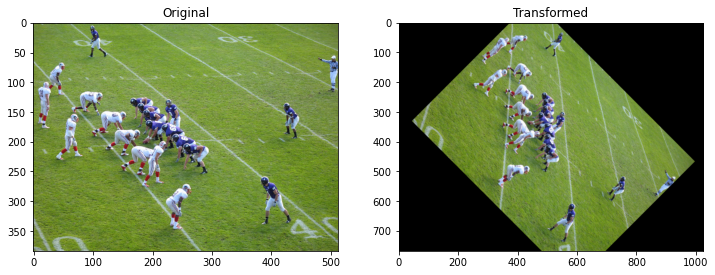

In [4]:
# Write your code here!

# Define transformation matrix
theta = pi/4
scale = 1.5
M = np.array([[scale*cos(theta), -scale*sin(theta), scale*300],[scale*sin(theta), scale*cos(theta), scale*(-50)], [0,0,1]], dtype=np.float64)

# Apply homography
n_rows = 2*image.shape[0]
n_cols = 2*image.shape[1]
transformed = cv2.warpPerspective(image, M, (n_cols,n_rows))

# Show the resulting image
plt.subplot(121)
plt.title("Original")
plt.imshow(image)
plt.subplot(122)
plt.title("Transformed")
plt.imshow(transformed);

### <span style="color:orange">LEVEL 4: Affine</span>

The affine transformation can be defined as:

$$\lambda \begin{bmatrix}x' \\ y' \\ 1 \end{bmatrix} = \begin{bmatrix} h_{00} & h_{01} & t_x \\ h_{10} & h_{11} & t_y \\ 0 & 0 & 1 \end{bmatrix}\begin{bmatrix}x \\ y \\ 1 \end{bmatrix} = \lambda \begin{bmatrix}h_{00}x + h_{01}y + t_x \\ h_{10}x + h_{11}y + t_y \\ 1 \end{bmatrix}\\[5pt]$$

This is an interesting homography because it appears quite often in real life (e.g. when the depth variation within the planar object and a camera is large):$\\[10pt]$

<img src="./images/affine.png" width="300" />$\\[5pt]$

We can deffine it as a **rotation + translation + scale (different for each axis)** transform.

### **<span style="color:green"><b><i>ASSIGNMENT 1d: Affine transformation, I choose you</i></b></span>**

Repeat the previous assignment but using an affine transformation, that is:

1. define the transformation matrix `M`,
2. apply it to the image,
3. show the initial and the resulting images.

<font color="blue">Output example:</font>

<img src="./images/affine_transformation.png" />

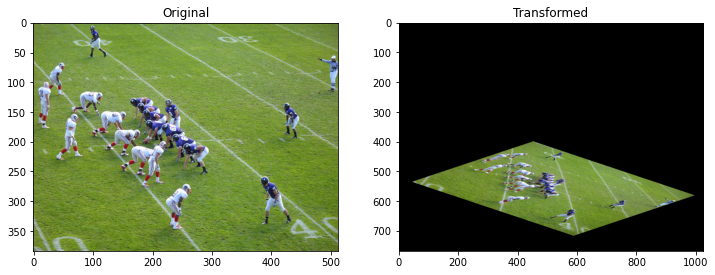

In [5]:
# Write your code here!

# Define transformation matrix
theta = pi/4
s_x = 1.5
s_y = 0.5
M = np.array([[s_x*cos(theta),-s_x*sin(theta),450],[s_y*sin(theta),s_y*cos(theta),400], [0,0,1]] , dtype=np.float64)

# Apply homography
n_rows = 2*image.shape[0]
n_cols = 2*image.shape[1]
transformed = cv2.warpPerspective(image, M, (n_cols,n_rows))

# Show the resulting image
plt.subplot(121)
plt.title("Original")
plt.imshow(image)
plt.subplot(122)
plt.title("Transformed")
plt.imshow(transformed);

### <span style="color:orange">LEVEL 5: Projective</span>

And we have reached the top level, the projective transformation:

$$\lambda \begin{bmatrix}x' \\ y' \\ 1 \end{bmatrix} = \begin{bmatrix} h_{00} & h_{01} & h_{02} \\ h_{10} & h_{11} & h_{12}\\ h_{20} & h_{21} & 1 \end{bmatrix}\begin{bmatrix}x \\ y \\ 1 \end{bmatrix} = \lambda \begin{bmatrix}h_{00}x + h_{01}y + h_{02}\\ h_{10}x + h_{11}y + h_{12}\\ h_{20}x + h_{21}y + 1 \end{bmatrix}\\[5pt]$$

This is the general 2D homography since there are no constraints. Unlike the affine transformation, projective transformations appear in real life when variation in depth is comparable to the distance from the camera to an object:$\\[10pt]$

<img src="./images/comparison_projective.png" width="650" />$\\[5pt]$

*Note that we used $h_{22}=1$ for fixing the scale factor in linear transformations. This constraint can be replaced with $\textbf{||h|| = 1}$ (better).*  

The projective transformation is a very powerful tool, and it has many applications. **Take a look at the following example:**

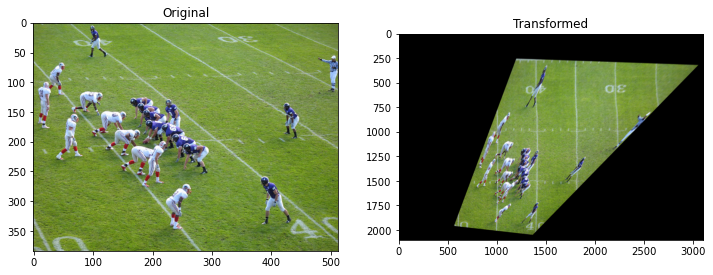

In [6]:
# Define transformation matrix
M = np.array([[3.1654,0.03225,1191.14702],[0.0799604,10.2911,263.9896],[-0.00014621,0.00300344,1]], dtype=np.float64)

# Apply homography
transformed = cv2.warpPerspective(image, M, (3100,2100))

# Show the resulting image
plt.subplot(121)
plt.title("Original")
plt.imshow(image)
plt.subplot(122)
plt.title("Transformed")
plt.imshow(transformed);

As you can see, the perspective of the image has been **removed** and the resultant (transformed) image is *like* an image taken from the air.

But, you can see that the coefficient of the employed transformation matrix are not some randomly picked numbers, so how can you obtain the specific matrix `M` that is able to do this? The short answer is from a set of corresponding points (rings any bell?). And going one step further: **How can a matrix `M` be obtained having pairs of correspondences**?  

Just as a preview, in the example above, we have used the four corners of the rectangle that the white lines are forming and we have made them corresponded with an actual rectangle without perspective. Do not worry, we will explain this later, but first let's have a look at the maths behind this.

## 8.3.2 Solving the 2D homography: Direct Lineal Transformation (DLT) <a id="832"></a>

As you know, a general 2D homography that converts a point $p=(x,y)$ to another point $p'=(x',y')$ looks like this (in homogeneous coordinates):$\\[5pt]$

$$\lambda \begin{bmatrix}x' \\ y' \\ 1 \end{bmatrix} = \begin{bmatrix} h_{00} & h_{01} & h_{02} \\ h_{10} & h_{11} & h_{12}\\ h_{20} & h_{21} & 1 \end{bmatrix}\begin{bmatrix}x \\ y \\ 1 \end{bmatrix}$$

If we know the coordinates of the corresponding points in both images, we can build an equations' system to solve the coefficients of the matrix. Furthermore, knowing a certain amount of corresponding points that share the same homography will allow us to get a(n) (over)determined equation system to get them.  

In this case, from a certain pair of points $i$, we can form a linear equations system in order to isolate the matrix variables:$\\[5pt]$

$$\begin{eqnarray}
x'_i = \frac{h_{00}x_i + h_{01}y_i + h_{02}}{h_{20}x_i + h_{21}y_i + 1}\  \longrightarrow \ x'_i(h_{20}x_i + h_{21}y_i + 1) = h_{00}x_i + h_{01}y_i + h_{02} \\[10pt]
y'_i = \frac{h_{10}x_i + h_{11}y_i + h_{12}}{h_{20}x_i + h_{21}y_i + 1}\ \longrightarrow \ y'_i(h_{20}x_i + h_{21}y_i + 1) = h_{10}x_i + h_{11}y_i + h_{12}
\end{eqnarray}
$$
$\\[10pt]$

This can be rewritten as: 

$$A\mathbf{h} = 0 \longrightarrow
\begin{bmatrix}
-x_i & -y_i & -1 & 0 & 0 & 0 & x'_ix_i & x'_iy_i & x'_i \\
0 & 0 & 0 & -x_i & -y_i & -1 & y'_ix_i & y'_iy_i & y'_i
\end{bmatrix} 
\begin{bmatrix}
h_{00} \\ h_{01} \\ h_{02} \\ h_{10} \\ h_{11} \\ h_{12} \\ h_{20} \\ h_{21} \\ 1
\end{bmatrix} 
=
\begin{bmatrix}
0 \\ 0 
\end{bmatrix} 
\\[5pt]
$$

You can see that with less than 4 independent points ($rank(A) \lt 8$), there are infinitely many solutions behind $k\textbf{h}$.

But, if we have **4 or more independent pair of points** we can build the following expression:$\\[5pt]$

$$Ah = 0 \longrightarrow
\begin{bmatrix}
-x_1 & -y_1 & -1 & 0 & 0 & 0 & x'_1x_1 & x'_1y_1 & x'_1 \\
0 & 0 & 0 & -x_1 & -y_1 & -1 & y'_1x_1 & y'_1y_1 & y'_1 \\
& & & &\vdots \\
-x_n & -y_n & -1 & 0 & 0 & 0 & x'_nx_n & x'_ny_n & x'_n \\
0 & 0 & 0 & -x_n & -y_n & -1 & y'_nx_n & y'_ny_n & y'_n \\
\end{bmatrix} 
\begin{bmatrix}
h_{00} \\ h_{01} \\ h_{02} \\ h_{10} \\ h_{11} \\ h_{12} \\ h_{20} \\ h_{21} \\ 1
\end{bmatrix} 
= 
\begin{bmatrix}
0 \\0\\ \vdots \\ 0 \\ 0
\end{bmatrix} 
$$


- For $\textbf{n = 4}$ **independent pair of points** ($rank(A) = 8$), there is a solution $k\textbf{h}$ with $\textbf{h} \ne 0, k \ne 0$. This should be sufficient (and strictly it is, as we will test later), but the solution will be highly affected by the noise in the points coordinates, so this is not usually employed in applications with automatically detected points, but for manually chosen ones.$\\[5pt]$
- For $\textbf{n > 4}$ **independent pair of points** ($rank(A) \gt 8$), (e.g. those pairs of points detected by SIFT or Harris) there is not a solution (apart from $\textbf{h} = 0$) as the system is overdetermined. However, we can get the solution that minimizes the error in the points coordinates (that is, the least-squares solution): $\\[5pt]$

    - Arg. min$_h ||\textbf{Ah}||^2$ with $||\textbf{h}|| = 1$$\\[5pt]$
    - Solution $\hat{h}$: eigenvector of the smallest eigenvalue of $A^TA$
    
Note that if you know the specific type of the transformation, you may need less points to solve this equation system:

- **Translation** (2 unknowns) $\rightarrow$ **1 pair of points needed**
- **Euclidean** (3 unknowns) $\rightarrow$ **2 pair of points needed**
- **Similarity** (4 unknowns) $\rightarrow$ **2 pair of points needed**
- **Affine** (6 unknowns) $\rightarrow$ **3 pair of points needed**
- **Projective** (8 unknowns) $\rightarrow$ **4 pair of points needed**

But, as we said, usually, you need many more points for noise robustness, so this is not relevant at all.  

Also, each type of transformation entails certain transformations and invariance, the table below resume this:$\\[10pt]$

<table>
<tbody>
<tr style="height: 23px;border: 1px solid black;">
<th style="height: 23px;border: 1px solid black;">&nbsp;</td>
<th style="height: 23px;border: 1px solid black;">Euclidean </td>
<th style="height: 23px;border: 1px solid black;">&nbsp;Similarity</td>
<th style="height: 23px;border: 1px solid black;">&nbsp;Affine</td>
<th style="height: 23px;border: 1px solid black;">&nbsp;Projective</td>
</tr>
<tr style="height: 23px;border: 1px solid black;">
<th style="height: 23px;border: 1px solid black;">&nbsp;Transformations:</td>
<td style="height: 23px;">&nbsp;</td>
<td style="height: 23px;">&nbsp;</td>
<td style="height: 23px;">&nbsp;</td>
<td style="height: 23px;">&nbsp;</td>
</tr>
<tr style="height: 23px;border: 1px solid black;">
<td style="height: 23px;border: 1px solid black;">&nbsp;Rotation, translation</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
</tr>
<tr style="height: 23px;border: 1px solid black;">
<td style="height: 23px;border: 1px solid black;">&nbsp;Isotropic scale</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
</tr>
<tr style="height: 23px;border: 1px solid black;">
<td style="height: 23px;border: 1px solid black;">&nbsp;Axes scale</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
</tr>
<tr style="height: 23px;border: 1px solid black;">
<td style="height: 23px;border: 1px solid black;">&nbsp;Perspective transformation</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
</tr>
<tr style="height: 23px;border: 1px solid black;">
<th style="height: 23px;border: 1px solid black;">&nbsp;Invariants:</td>
<td style="height: 23px;">&nbsp;</td>
<td style="height: 23px;">&nbsp;</td>
<td style="height: 23px;">&nbsp;</td>
<td style="height: 23px;">&nbsp;</td>
</tr>
<tr style="height: 23px;border: 1px solid black;">
<td style="height: 23px;border: 1px solid black;">&nbsp;Distance</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
</tr>
<tr style="height: 23px;border: 1px solid black;">
<td style="height: 23px;border: 1px solid black;">&nbsp;Angles, distance ratios</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
</tr>
<tr style="height: 23px;border: 1px solid black;">
<td style="height: 23px;border: 1px solid black;">Parallelism, mass center</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;</td>
</tr>
<tr style="height: 23px;border: 1px solid black;">
<td style="height: 23px;border: 1px solid black;">&nbsp;Cross-ratio</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
<td style="height: 23px;border: 1px solid black;">&nbsp;x</td>
</tr>
</tbody>
</table>

### Let's apply your knowledge!

Now that we know how to solve the 2D homography, let's go back to our American football problem.

We are going to work with the image `football-big.jpg`, which is the same as the one used in previous exercises but with a better resolution and quality.

Let's start by reading and showing such color image:

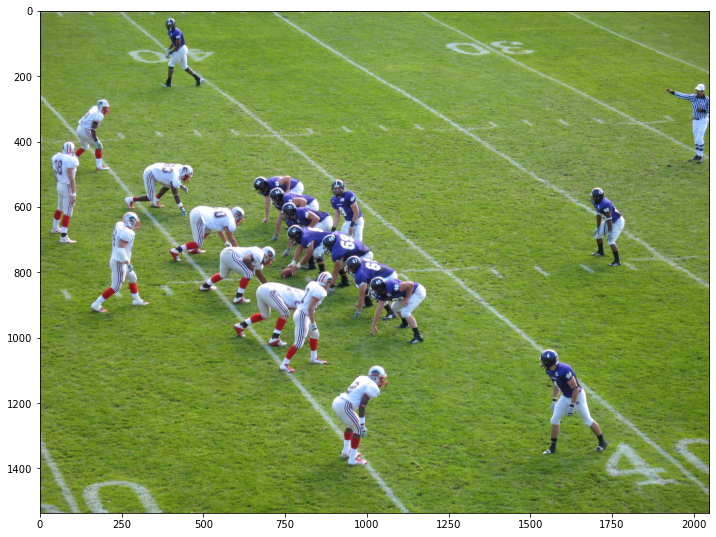

In [7]:
# Write your code here!

matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

# Read american football image.
image = cv2.imread(images_path + 'football-big.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

# Show it
plt.imshow(image);

Our first task is to add the image `marker.jpg` to the field. 

<img src="./images/marker.jpg" width="150" />$\\[5pt]$

Recall that this means: 3rd (try) & 3 (yards to go). For adding an image without perspective to an image with perspective, the first step is to **remove the perspective** of the original image, and for that we are going to *map* the points of a rectangle on the field to **an actual rectangle**, but keeping the ratio of the sides' lengths of the rectangle (remember that a projective transformation is only invariant to the cross-ratio distances!):

<img src="./images/points-homography.png" width="800" />$\\[5pt]$

Now that we have four (manually selected) corresponding points, we are going to compute the transformation matrix of that projective homography. This is easy in openCV, as it provides the [`cv2.findHomography()`](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780) method, which takes two lists of corresponding points as input: 
- the first list contains the input coordinates $(x_i,y_i)$ and 
- the second list their correspondences $(x'_i,y'_i)$.

*Note that those points represent coordinates, their format is $(n\_col, n\_row)$*.

### **<span style="color:green"><b><i>ASSIGNMENT 2a: Obtaining the transformation matrix</i></b></span>**

**Your task here is** to retrieve the transformation matrix that transforms points from the image with perspective to the one without it. For that:

1. Take the **four corners of the specified rectangle** (you can use an external tool to get the coordinates),
2. and obtain the transformation matrix that removes the perspective of the football field. For that you have to define two pairs of correspondences, `pts_src` and `pts_dst`, linking points in the first image with points in the second one. 
3. Then **use [`cv2.warpPerspective()`](https://docs.opencv.org/4.2.0/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87) with the obtained matrix** to remove the perspective and **show the resultant image**. 
4. Finally, save it into your computer, we will need it for the next exercise.

*Remember that the output rectangle should maintain the ratio of the original football field ($10\ /\ 6.16$) when you define the list of the correspondent points, and for computation purposes use numbers that are "similar".*

<font color="blue">Expected output in the next assignment.</font>

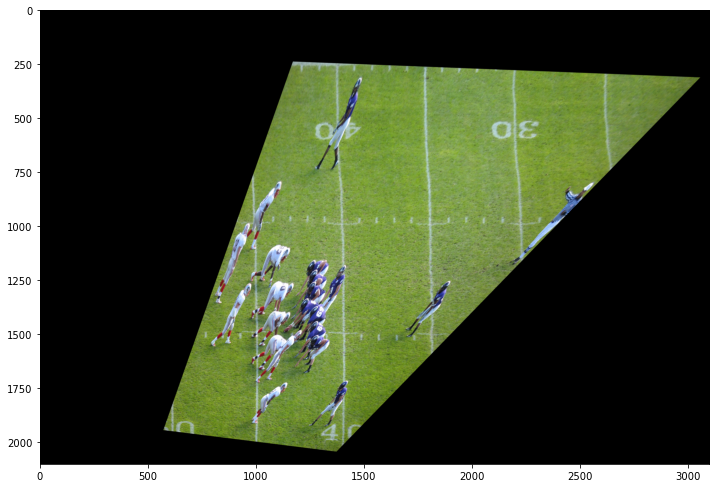

In [8]:
# Write your code here!

# Points of a rectangle in the field
pts_src = np.array([[150, 410],[520,840],[1300, 370],[1900, 760]])

# Points of a rectangle without perspective with r=1.6
pts_dst = np.array([[1000, 1000], [1000, 1500], [1805, 1000],[1805, 1500]])

# Calculate Homography
M, status = cv2.findHomography(pts_src, pts_dst)

# Warp source image to destination based on homography
no_perspective = cv2.warpPerspective(image, M, (3100,2100))

# Show image without perspective
plt.imshow(no_perspective)

# Save image
im_out = cv2.cvtColor(no_perspective,cv2.COLOR_RGB2BGR)
cv2.imwrite(images_path + "no_perspective.jpg",im_out);

### Overlapping an image

Now that we have the field without perspective, we can add the marker to the image in any place.

As we want to **add the start and down line in the original image**, we need to **take two points for each line in this image** (note that now the lines are vertical lines, so take points with the same $x$ coordinate for both lines). In the next exercise we will apply inverse homography to those points so it will be possible to draw the line in the original image. **The down line should be at 3 yards of the start line** (each small vertical segment marks one yard, and vertical lines mark five yards).

### **<span style="color:green"><b><i>ASSIGNMENT 2b: Adding the marker</i></b></span>**

Add the marker to the image without perspective and show it, also take the points mentioned before. The resulting image should look like this:$\\[5pt]$

<img src="./images/marker-example.png" width="600" />$\\[5pt]$

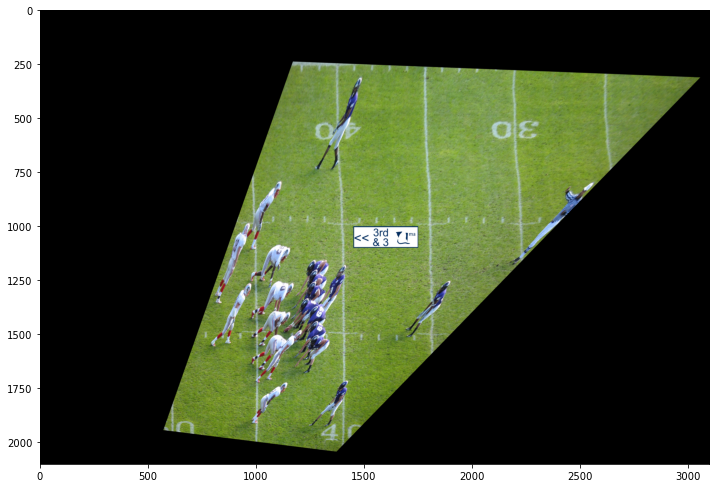

In [9]:
# Write your code here!

# Read the marker image.
marker = cv2.imread(images_path + 'marker.jpg')
marker = cv2.cvtColor(marker,cv2.COLOR_BGR2RGB)

# Get width and height of the marker
h,w = marker.shape[:2]

# Choose position of marker
x, y = 1450, 1000

# Place marker in football field image without perspective
no_perspective[y:y+h, x:x+w] = marker

# Show image
plt.imshow(no_perspective)

# Pick two homogenous points contained in the start line
start_line = np.array([[1200,1200,1],[1750,868,1],[1,1,1]])

# Pick two homogenous points contained in the down line
down_line = np.array([[900,920,1],[880,1530,1],[1,1,1]]);

### Augmented reality

It's time to restore the initial perspective, for that **apply an homography using the inverse of the transformation matrix**:

$$\lambda \begin{bmatrix}x \\ y \\ 1 \end{bmatrix} = \begin{bmatrix} h_{00} & h_{01} & h_{02} \\ h_{10} & h_{11} & h_{12}\\ h_{20} & h_{21} & 1 \end{bmatrix}^{-1}\begin{bmatrix}x' \\ y' \\ 1 \end{bmatrix}$$

### **<span style="color:green"><b><i>ASSIGNMENT 2c: Going back to the initial perspective, but with the mark!</i></b></span>**

Compute the inverse of the transformation matrix using [`numpy.linalg.inv()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.inv.html), and bring back the perspective to the image with the marker using the new homography. Then show it.

*Now, you should see the marker having the same perspective than the original image.*

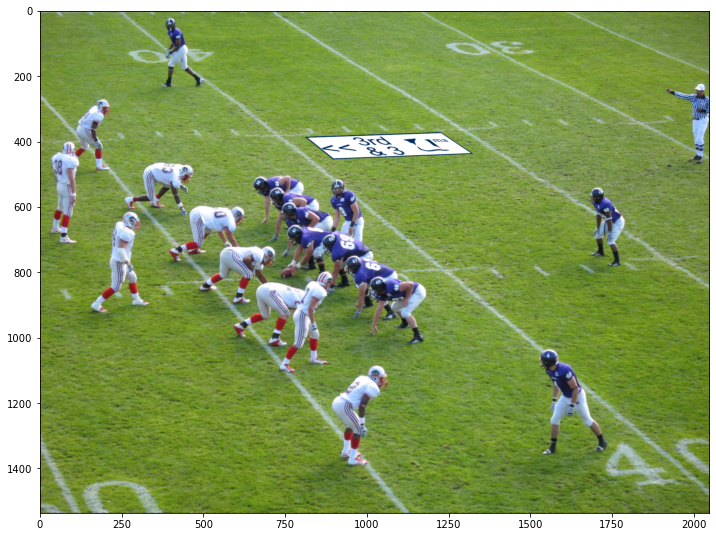

In [10]:
# Write your code here!

# Compute the inverse of the homography
invM = np.linalg.inv(M)

# Get the original perspective again
n_rows = image.shape[0]
n_cols = image.shape[1]
perspective = cv2.warpPerspective(no_perspective, invM, (n_cols,n_rows))

# Show the image
plt.imshow(perspective);

### Time to include the lines

Finally, its time to **draw the lines**. You should have saved the coordinates of two points for each line in the image without perspective.

For homography of lines, you just need to **apply the homography to two points of the line**. In that way, you will have two points in the original image defining the line.

Note that `cv2.line()` has two points as input, but only draws the segment line. You will have to **extend that segment** using the slope of the line.

$$slope = \frac{y_2-y_1}{x_2-x_1}$$

The new points will be:

$$\begin{eqnarray}
x'_1,\ \  y'_1 = x_1 + extension,\ \ y_1 + extension\times slope\\[3pt]
x'_2,\ \  y'_2 = x_2 - extension,\ \  y_2 - extension\times slope
\end{eqnarray}$$

### **<span style="color:green"><b><i>ASSIGNMENT 2d: Drawing lines</i></b></span>**

Apply the **inverse homography** to the line points, **extend** the line segment and **draw** the start line (blue) and the down line (yellow). Finally, show the resulting image.

This resulting image should look like this:$\\[5pt]$

<img src="./images/result.png" width="400" />$\\[5pt]$

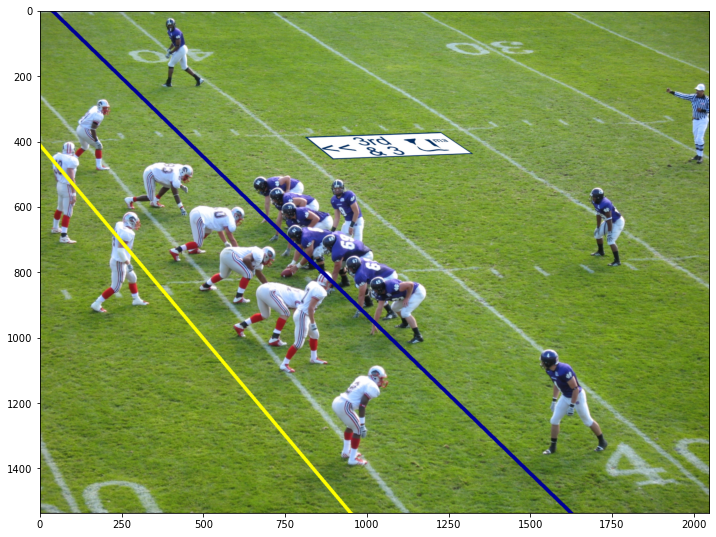

In [11]:
# Write your coude here!

# Apply inverse homography to the start line points taken in the image without perspective
start_line_perspective = invM @ start_line
start_line_perspective = (start_line_perspective / start_line_perspective[2])[0:2]

x1,y1 = start_line_perspective[0,0], start_line_perspective[1,0]
x2,y2 = start_line_perspective[0,1], start_line_perspective[1,1]

# Compute the slope for extending the line segment
slope = (y2-y1)/(x2-x1)

# Extend the line segment
ext = 3000
x1,y1 = int(x1+ext), int(y1+ext*slope)
x2,y2 = int(x2-ext), int(y2-ext*slope)

# Draw the start line
pers_with_lines = perspective.copy()
pers_with_lines = cv2.line(pers_with_lines, (x1,y1), (x2,y2),thickness=10,color=[0,0,150])

# Apply inverse homography to the down line points taken in the image without perspective
down_line_perspective = invM @ down_line
down_line_perspective = (down_line_perspective / down_line_perspective[2])[0:2]

x1,y1 = down_line_perspective[0,0], down_line_perspective[1,0]
x2,y2 = down_line_perspective[0,1], down_line_perspective[1,1]

# Compute the slope for extending the line segment
slope = (y2-y1)/(x2-x1)

# Extend the line segment
x1,y1 = int(x1+3000), int(y1+3000*slope)
x2,y2 = int(x2-3000), int(y2-3000*slope)

# Draw the start line
pers_with_lines = cv2.line(pers_with_lines, (x1,y1), (x2,y2),thickness=10,color=[255,255,0])

# And... show the final image!
plt.imshow(pers_with_lines);

### A second way when dealing with lines: using its equation

An alternative way to apply an homography to a line is by considering its equation:

$$ax+by+c=0$$

So $l=[a,b,c]^T$. In this way, a vertical line in the image without projection would be represented by a vector in this form $l'=[1, 0, -x]^T$, so we just need the $x$ coordinate (column) to build such line!

Once we have the $l'$ line, the same homography used for transforming points can be used here for obtaining its equivalent in the image with projection:

$$l = H^T l'$$

Amazing, isn't? Take a look at the following code which carries out this computations and provides the same results as before.

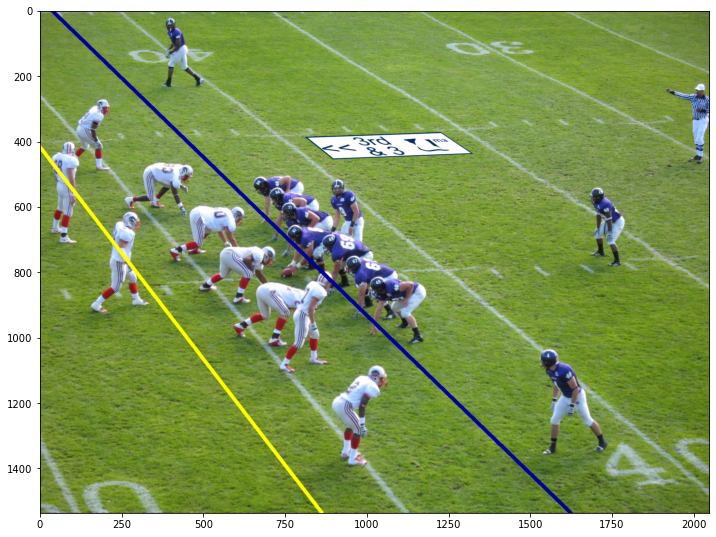

In [17]:
pers_with_lines = perspective.copy()

x1 = start_line[0,0]

l_h = np.vstack(np.array([1,0,-x1]))

l = M.T@l_h
n_y1 = int(0)
n_y2 = int(pers_with_lines.shape[0])
n_x1 = int((-l[1]*n_y1-l[2])/l[0])
n_x2 = int((-l[1]*n_y2-l[2])/l[0])
pers_with_lines = cv2.line(pers_with_lines, (n_x1,n_y1), (n_x2,n_y2),thickness=10,color=[0,0,155])

x1 = down_line[0,0]

l_h = np.vstack(np.array([1,0,-x1]))

l = M.T@l_h
n_y1 = int(0)
n_y2 = int(perspective.shape[0])
n_x1 = int((-l[1]*n_y1-l[2])/l[0])
n_x2 = int((-l[1]*n_y2-l[2])/l[0])
pers_with_lines = cv2.line(pers_with_lines, (n_x1,n_y1), (n_x2,n_y2),thickness=10,color=[255,255,0])

plt.imshow(pers_with_lines);

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

**Now you are in a good position to answer these questions:**

- Could you have retrieved the homography M by using 3 correspondences between points in assignment 2? Why?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>No, ya que al tratarse de un caso de distacias euclídeas necesitaremos al menos 2 pares de puntos para determinar la matriz de manera acertada. </i></p>
    
- Could you have retrieved the homography M by using 5 correspondences between points in assignment 2? If yes, how?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Sí, ya que superamos el número mínimo de 4 puntos.</i></p>
  
- Why did we need to apply a projective transformation in our American football application in assignment 2? Could it be replaced by any other?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Como necesitamos trazar las líneas y colocar el logo en perspectiva, tenemos que aplicar una transformación que elimine ese efecto de perspectiva y colocarlo para después deshacer el cambio. Podríamos realizar una transformación afín que tuviera los mismos efectos.</i></p>
    
- What kind of transformation does the following matrix define? 

      [[  1.06066017  -1.06066017 450.        ]
      [  1.06066017   1.06066017 -75.        ]
      [  0.           0.           1.        ]]

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Podemos afirmar que se trata de una rotación (con ángulo de 45º ya que su seno es igual al coseno) y una translación (450 uds sobre el eje OX y de -75 sobre el eje OY). También vemos que no se aplica ningún tipo de escala.</i></p>

## 8.3.3 When can a homography be applied? <a id="833"></a>

We have applied a homography to this football field because it is a transformation **between planes**, but if you look to the top player in the *aerial* image, you can see that the transformation is not good at all. So, we need to know when can we apply a homography. 

It can be said that there is a homography $H_{3\times3}$ between points in these 3 cases:

<img src="./images/applications.png" width="800" />

In this exercise we have emulated a **still camera** and we have transformed an image plane to another. Since the players are not in the same plane that the football field, the homography is not valid for those points.

On the other hand, there is also a homography **for a rotating camera observing a non-planar scene**. Actually, this would be the next step for **image stitching** after computing matches with keypoints in the example application in Chapter 4. We have already the correspondences either using Harris or SIFT, so the homography should be easy to obtain.$\\[5pt]$

<img src="./images/stitching.png" width="800" />$\\[5pt]$

Finally, there are a homography for a **moving camera observing a plane**. This is the typical case of 2 images of a painting taken from different positions:$\\[5pt]$

<img src="./images/painting.png" width="400" />

## Conclusion

Fantastic work! Homographies are a very important tool in computer vision. In this notebook you have learned:

- what a homography is, how to solve it and how to apply it,
- when a homography can be used,
- how to apply homographies to lines,
- some homography applications that are currently being used in American football (and other sports too! think about placing advertising on a tennis or football courts).